<a href="https://colab.research.google.com/github/Imparth2803/Data-Science-Project/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import cv2


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers

import zipfile
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extracting dataset from zipfile

In [2]:
# Define file paths
zip_path = "/content/drive/MyDrive/ISIC_2019_Training_Input.zip"
csv_path = "/content/drive/MyDrive/ISIC_2019_Training_Metadata.csv"
extract_path = "/content/ISIC_2019_Training_Input"

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Exploratory Data Analysis(EDA)

In [3]:
df = pd.read_csv(csv_path)

# Display first 5 rows
print(df.head())

# Show dataset info
df.info()

print(df.isnull().sum())

          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
image                     0
age_approx              437
anatom_site_general    2631
lesion_i

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Fill missing values
df['age_approx'] = df['age_approx'].fillna(df['age_approx'].median())

# Fill missing sex values with "unknown"
df['sex'] = df['sex'].fillna("unknown")

# Verify again
print(df.isnull().sum())

Missing Values:
 image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dtype: int64
image                     0
age_approx                0
anatom_site_general    2631
lesion_id              2084
sex                       0
dtype: int64


In [5]:
# Drop rows with null values in the "anatom_site_general" column
df = df.dropna(subset=['anatom_site_general'])

df = df.dropna(subset=['lesion_id'])

# Verify
print(df.isnull().sum())

image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dtype: int64


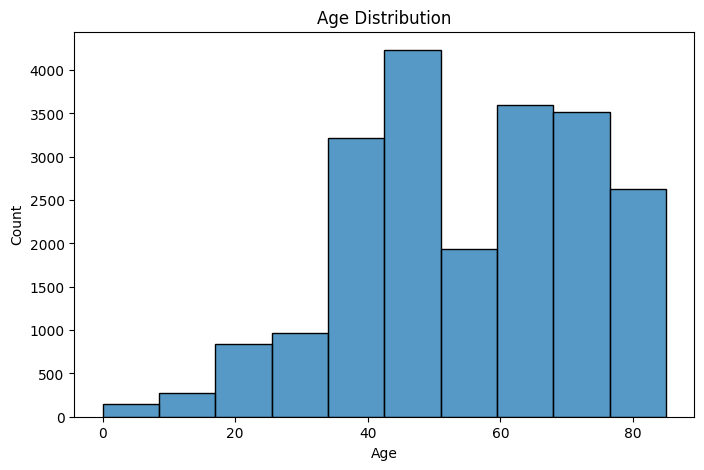

In [6]:
# Age distribution histogram graph

plt.figure(figsize=(8, 5))
sns.histplot(df["age_approx"], bins=10)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

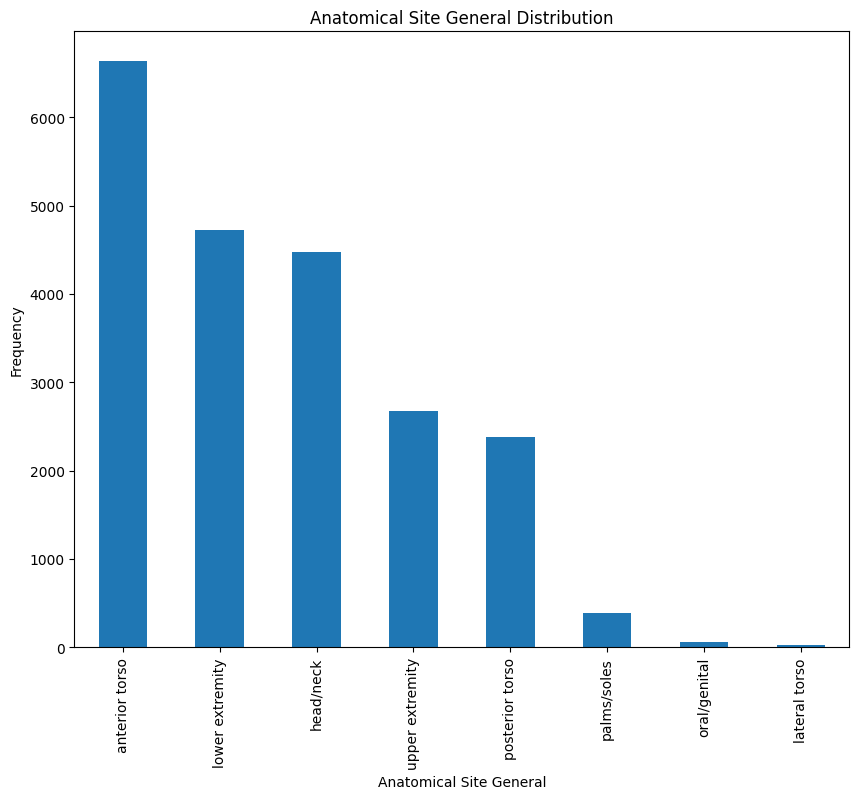

In [7]:
# Anatomic Site General Distribution of given dataset

plt.figure(figsize=(10, 8))
df['anatom_site_general'].value_counts().plot(kind='bar')
plt.title('Anatomical Site General Distribution')
plt.xlabel('Anatomical Site General')
plt.ylabel('Frequency')
plt.show()

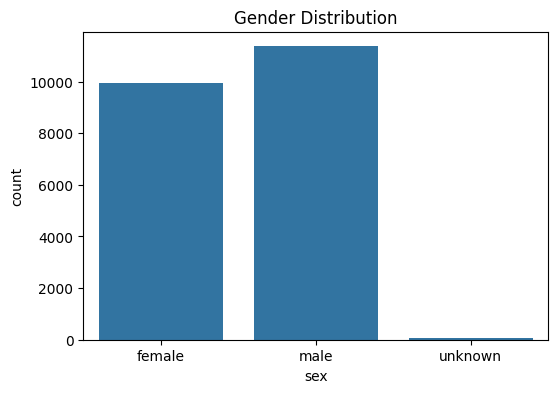

In [8]:
# Gender distribution

plt.figure(figsize=(6, 4))
sns.countplot(x="sex", data=df)
plt.title("Gender Distribution")
plt.show()

In [9]:
# Lesion category csv file
lesion_path = "/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv"
df_lesion = pd.read_csv(lesion_path)

# Display first 5 rows
print(df_lesion.head())

# Show dataset info
df_lesion.info()

print(df_lesion.isnull().sum())

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
image    0
MEL      0
N

MEL      4522.0
NV      12875.0
BCC      3323.0
AK        867.0
BKL      2624.0
DF        239.0
VASC      253.0
SCC       628.0
UNK         0.0
dtype: float64


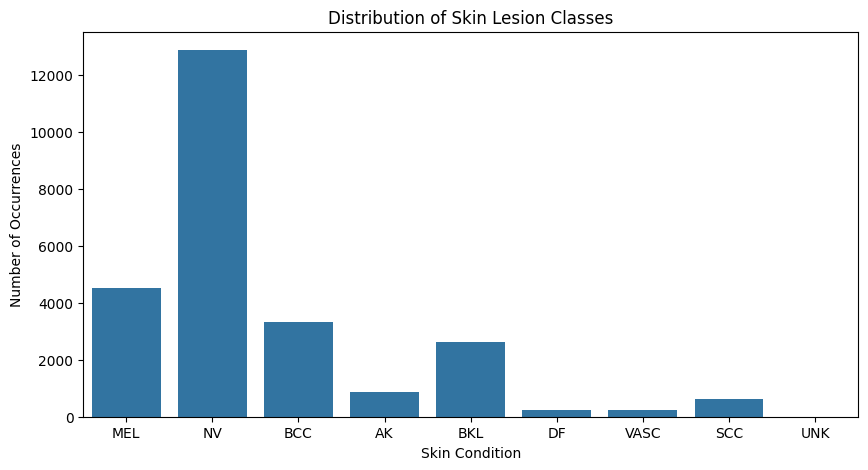

In [10]:
positive_counts = df_lesion.iloc[:, 1:].sum()
print(positive_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=positive_counts.index, y=positive_counts.values)
plt.xlabel("Skin Condition")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Skin Lesion Classes")
plt.show()

# Preprocessing Images

In [11]:
# Load the CSV file
csv_path = "/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv"
df = pd.read_csv(csv_path)

image_column = df.columns[0]
class_columns = df.columns[1:]

# Convert one-hot encoding back to categorical labels
df["Disease"] = df[class_columns].idxmax(axis=1)

# Keep only two columns: Image name and Disease label
df = df[[image_column, "Disease"]]

# Save the updated CSV
df.to_csv("updated_dataset.csv", index=False)

updated_csv = "/content/updated_dataset.csv"
df_updated = pd.read_csv(updated_csv)

# Display first 5 rows
print(df_updated.head())

# Show dataset info
df_updated.info()

print(df_updated.isnull().sum())

          image Disease
0  ISIC_0000000      NV
1  ISIC_0000001      NV
2  ISIC_0000002     MEL
3  ISIC_0000003      NV
4  ISIC_0000004     MEL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    25331 non-null  object
 1   Disease  25331 non-null  object
dtypes: object(2)
memory usage: 395.9+ KB
image      0
Disease    0
dtype: int64


# load_and_preprocess_image, one_hot_encode, get_isic_dataset

In [12]:
def load_and_preprocess_image(image_path, label, image_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def one_hot_encode(image, label, num_classes):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def get_dataset(image_dir, csv_path, image_size=64, batch_size=64, samples_per_class=250):
    df = pd.read_csv(csv_path)

    # Encode text labels
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Disease'])
    num_classes = len(label_encoder.classes_)

    image_paths = [os.path.join(image_dir, fname + ".jpg") for fname in df['image']]
    labels = df['Label'].values

    selected_paths = []
    selected_labels = []

    for class_id in range(num_classes):
        idx = np.where(labels == class_id)[0][:samples_per_class]
        selected_paths.extend([image_paths[i] for i in idx])
        selected_labels.extend([labels[i] for i in idx])

    dataset = tf.data.Dataset.from_tensor_slices((selected_paths, selected_labels))
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y, image_size))
    dataset = dataset.map(lambda x, y: one_hot_encode(x, y, num_classes))
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, num_classes, label_encoder

In [13]:
image_dir = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
csv_path = "/content/updated_dataset.csv"

# Load data
dataset, num_classes, label_encoder = get_dataset(image_dir, csv_path)

# Split into train/val (80/20)
total = 0
for _ in dataset:
    total += 1
train_size = int(0.8 * total)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [14]:
from tensorflow.keras import layers, models, regularizers

def create_cnn(input_shape=(64, 64, 3), num_classes=8):
    weight_decay = 1e-4

    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.25),

        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
from tensorflow.keras.metrics import AUC

cnn_model = create_cnn(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

cnn_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

cnn_model.summary()

history = cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=150)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 306,344 (1.17 MB)

 Trainable params: 305,448 (1.17 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.2950 - auc: 0.6727 - loss: 2.0509 - val_accuracy: 0.1620 - val_auc: 0.5008 - val_loss: 2.1489
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.2746 - auc: 0.7073 - loss: 1.9776 - val_accuracy: 0.1954 - val_auc: 0.5109 - val_loss: 2.5054
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.2892 - auc: 0.7324 - loss: 1.8867 - val_accuracy: 0.1105 - val_auc: 0.4837 - val_loss: 3.0422
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.3625 - auc: 0.7685 - loss: 1.7768 - val_accuracy: 0.1620 - val_auc: 0.4832 - val_loss: 3.3687
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.3704 - auc: 0.7817 - loss: 1.7345 - val_accuracy: 0.1517 - val_auc: 0.4667 - val_loss: 3.7411
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.3627 - auc: 0.7955 - loss: 1.6983 - val_accuracy: 0.1568 - val_auc: 0.5065 - val_loss: 3.2308
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/

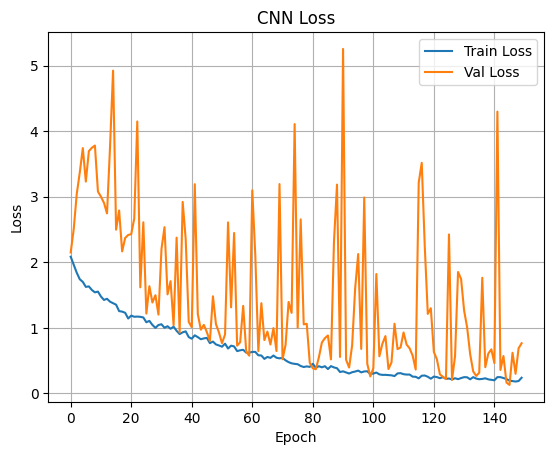

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Loss')
plt.grid(True)
plt.show()

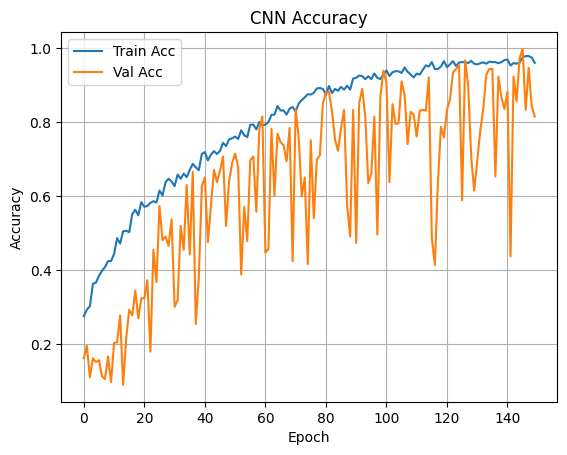

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Accuracy')
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Classification Report:
              precision    recall  f1-score   support

          AK       0.58      0.84      0.69        38
         BCC       0.72      0.85      0.78        34
         BKL       0.97      0.94      0.96        36
          DF       0.79      0.79      0.79        38
         MEL       1.00      0.37      0.54        38
          NV       0.79      0.92      0.85        48
         SCC       0.85      0.66      0.74        61
        VASC       0.88      0.96      0.92        96

    accuracy                           0.81       389
   macro avg       0.82      0.79      0.78       389
weighted avg       0.83      0.81      0.80       389



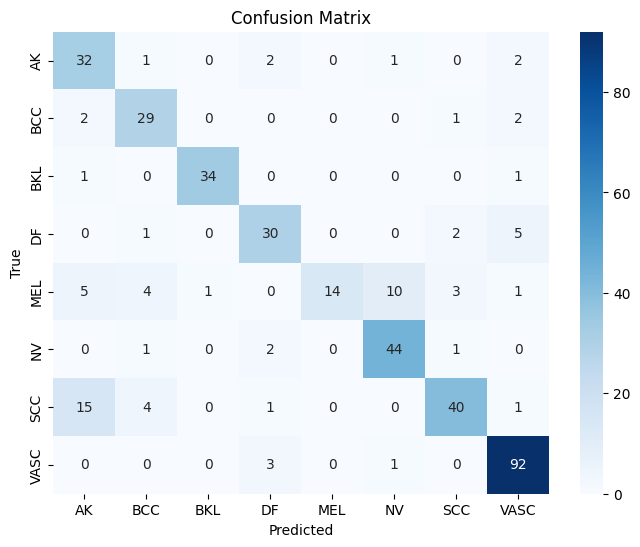

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract all true and predicted labels
y_true, y_pred = [], []

for images, labels in val_dataset:
    preds = cnn_model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save the trained CNN model
cnn_model.save('/content/cnn_model_isic.h5')

In [ ]:
from google.colab import files
files.download('/content/cnn_model_isic.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [16]:
class ISICDataset(Dataset):
    def __init__(self, image_dir, csv_path, image_size=64, samples_per_class=250, transform=None):
        self.image_dir = image_dir
        self.image_size = image_size
        self.transform = transform

        df = pd.read_csv(csv_path)
        self.label_encoder = LabelEncoder()
        df['Label'] = self.label_encoder.fit_transform(df['Disease'])

        image_paths = [os.path.join(image_dir, fname + ".jpg") for fname in df['image']]
        labels = df['Label'].values

        selected_paths = []
        selected_labels = []

        for class_id in range(len(self.label_encoder.classes_)):
            idx = np.where(labels == class_id)[0][:samples_per_class]
            selected_paths.extend([image_paths[i] for i in idx])
            selected_labels.extend([labels[i] for i in idx])

        self.images = selected_paths
        self.labels = selected_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [17]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [18]:
# Set paths
image_dir = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
csv_path = "/content/updated_dataset.csv"

# Create dataset and loaders
full_dataset = ISICDataset(image_dir, csv_path, image_size=64, samples_per_class=200, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

In [19]:
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [20]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

In [21]:
import torch
import torch.nn as nn

class SimpleViT(nn.Module):
    def __init__(self, image_size=64, patch_size=8, num_classes=8, dim=128, depth=6, heads=8, mlp_dim=256, dropout=0.25):
        super(SimpleViT, self).__init__()
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"

        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size * patch_size

        self.patch_size = patch_size
        self.to_patch_embedding = nn.Sequential(
    nn.Conv2d(3, dim // 2, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(dim // 2),
    nn.ReLU(),

    nn.Conv2d(dim // 2, dim, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(dim),
    nn.ReLU(),

    nn.Conv2d(dim, dim, kernel_size=patch_size // 4, stride=patch_size // 4),
    nn.Flatten(2)
)

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        x = x.transpose(1, 2)
        batch_size, num_patches, dim = x.shape

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding[:, :(num_patches + 1)]
        x = self.dropout(x)
        x = self.transformer(x)
        x = x[:, 0]
        x = self.mlp_head(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleViT(image_size=64, patch_size=8, num_classes=len(full_dataset.label_encoder.classes_)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 50

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct / total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    epoch_val_loss = val_running_loss / len(test_loader)
    epoch_val_acc = val_correct / val_total

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

Epoch [1/50] | Train Loss: 1.9433, Train Acc: 0.2336 | Val Loss: 1.6943, Val Acc: 0.3250
Epoch [2/50] | Train Loss: 1.7238, Train Acc: 0.3344 | Val Loss: 1.5837, Val Acc: 0.3500
Epoch [3/50] | Train Loss: 1.6539, Train Acc: 0.3547 | Val Loss: 1.5738, Val Acc: 0.3812
Epoch [4/50] | Train Loss: 1.5488, Train Acc: 0.4070 | Val Loss: 1.4931, Val Acc: 0.4437
Epoch [5/50] | Train Loss: 1.4835, Train Acc: 0.4273 | Val Loss: 1.5018, Val Acc: 0.4437
Epoch [6/50] | Train Loss: 1.4212, Train Acc: 0.4523 | Val Loss: 1.4245, Val Acc: 0.4594
Epoch [7/50] | Train Loss: 1.3903, Train Acc: 0.4617 | Val Loss: 1.4256, Val Acc: 0.4781
Epoch [8/50] | Train Loss: 1.3454, Train Acc: 0.5000 | Val Loss: 1.3858, Val Acc: 0.4656
Epoch [9/50] | Train Loss: 1.2813, Train Acc: 0.5008 | Val Loss: 1.4229, Val Acc: 0.4750
Epoch [10/50] | Train Loss: 1.3022, Train Acc: 0.4773 | Val Loss: 1.3864, Val Acc: 0.4813
Epoch [11/50] | Train Loss: 1.2739, Train Acc: 0.5031 | Val Loss: 1.3766, Val Acc: 0.4750
Epoch [12/50] | Tra

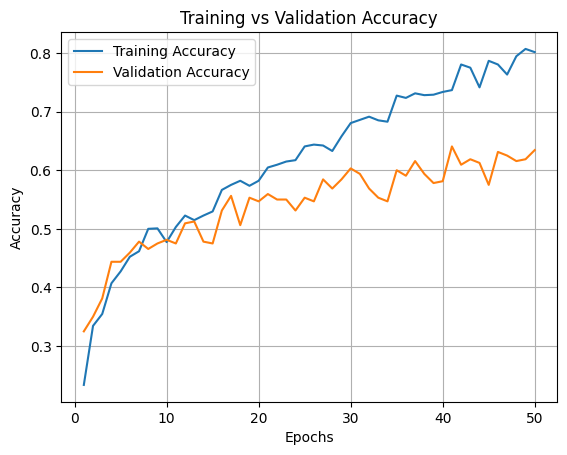

In [ ]:
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

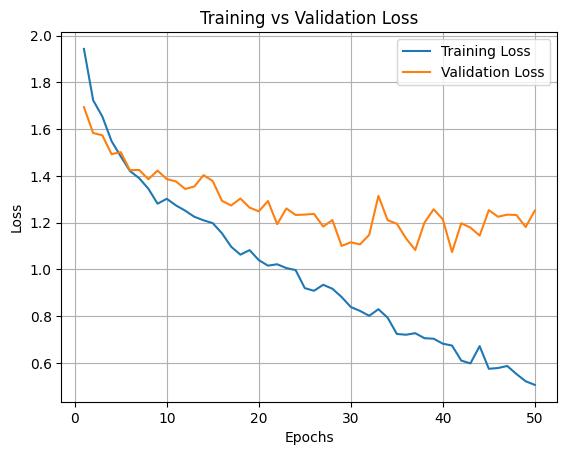

In [ ]:
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save model
torch.save(model.state_dict(), '/content/simple_vit_isic.pth')

# Download model
from google.colab import files
files.download('/content/simple_vit_isic.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>